### 总结：Quantum Variational Autoencoder（QVAE）原理与代码实现

---

## 一、QVAE 原理概括

QVAE（Quantum Variational Autoencoder）是一种将 **量子生成模型** 引入 **变分自编码器(VAE)** 潜空间的生成模型。其核心思想是：

> **用量子玻尔兹曼机（QBM）替代传统VAE中的先验分布，从而构建一个具有量子生成能力的潜变量模型。**

### 模型结构

QVAE 包括以下关键组件：

1. **编码器（Encoder）**：  
   将输入数据 x 映射为潜变量的近似后验分布  
   $q_\phi(z|x)$，通常由神经网络参数化。

2. **先验分布（Prior）**：  
   使用 **量子玻尔兹曼机(QBM)** 建模潜变量 z 的先验分布。哈密顿量为：  
   $$
   \mathcal{H}_\theta = \sum_l \Gamma_l \sigma_l^x + \sum_l h_l \sigma_l^z + \sum_{l<m} W_{lm} \sigma_l^z \sigma_m^z
   $$

3. **解码器（Decoder）**：  
   将潜变量 z（或其连续松弛变量 $\zeta$）映射回数据空间，并使用解码器重建原始数据：  
   $$
   p_\theta(\mathbf{x} | \boldsymbol{\zeta}) \approx \text{Bernoulli}(f_\theta(\boldsymbol{\zeta}))
   $$

### 训练目标：Q-ELBO

QVAE 使用一个 **量子下界(Q-ELBO)** 来近似最大化对数似然：

$$
\mathcal{L}_{\text{Q-ELBO}} = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})} [\log p_\theta(\mathbf{x} | \boldsymbol{\zeta})] - \tilde{H}(q_\phi(\mathbf{z}|\mathbf{x}) \| p_\theta(\mathbf{z}))
$$

### QBM采样与训练

- **正相（positive phase）**：从编码器采样  $z \sim q_\phi(z|x)$
- **负相（negative phase）**：从 QBM 中采样 $z \sim p_\theta(z)$，使用 **蒙特卡洛方法** 或 **量子退火器**
把能量作为目标函数，objective的梯度即为基于正相和负相采样计算的梯度

## 二、代码架构概述

```bash

QVAE 完整训练流程
│
├── 1. 数据准备 (setup_data_loaders)
│   ├── MNIST数据集加载
│   ├── 图像展平预处理 (784维向量)
│   └── 训练/测试集划分
│
├── 2. 模型构建 (QVAE)
│   ├── 编码器 (Encoder)
│   ├── 解码器 (Decoder) 
│   └── RBM先验 (RestrictedBoltzmannMachine)
│
├── 3. 模型训练 (train_qvae)
│   ├── 前向传播 (neg_elbo计算)
│   ├── 反向传播 (梯度更新)
│   └── 训练过程监控与保存
│
├── 4. 潜变量特征提取 (extract_qvae_latent_features)
│   ├── 从训练集提取潜变量
│   └── 准备分类器训练数据
│
├── 5. MLP分类器训练 (train_mlp_classifier)
│   ├── 基于潜变量特征的分类
│   ├── 训练-验证集划分 (60%-40%)
│   └── 准确率优化与模型保存
│
└── 6. 综合评估与分析
    ├── t-SNE潜空间可视化
    ├── 统计特性分析
    ├── 混淆矩阵评估
    └── 最终测试集准确率计算
```

## 三、代码内容概括

该例子实现了一个 **用于 MNIST 的 QVAE-Classifier(MLP) 训练流程**，包括以下模块：

### 模型构建

- 使用自定义 `QVAE` 类：
  - 编码器/解码器为全连接网络；
  - 使用 `mean_x` 作为模型偏移量；
  - 包含玻尔兹曼机作为先验分布

- `MLP` 分类器：
  - 输入维度：潜变量维度 (256)
  - 输出维度：数字类别数 (10)

### 训练过程

##### QVAE 无监督训练
- 优化器：Adam，学习率 1e-3；
- 损失函数：`loss = neg_elbo + wd_loss`，即包含ELBO下界和weight decay
- 每个 epoch 保存模型权重；
- 记录并保存以下历史数据：
  - `loss_history`
  - `elbo_history`
  - `kl_history`
  - `cost_history`

##### MLP 有监督训练
- 在潜变量特征上训练MLP分类器
- 使用验证集监控模型性能
- 自动保存最佳准确率模型

### 评估指标
- `t-SNE`可视化：分析潜空间结构
- 统计特性分析：各类别分布统计
- 混淆矩阵：可视化检验模型的表现
- 最终测试准确率：模型泛化能力评估

## 四、总结

> QVAE = VAE 的编码器/解码器 + QBM 的量子先验，通过最大化量子下界（Q-ELBO）实现端到端训练；  
> QVAE + MLP分类器 = 无监督特征学习 + 有监督分类评估的完整流程；  
> 代码包含MNIST 数据集，QVAE 模型，训练循环，潜变量特征提取，分类器训练，t-SNE可视化和混淆矩阵评估，完整实现了量子启发自编码器在特征学习与分类任务中的端到端验证流程。

In [1]:
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, FashionMNIST, KMNIST
from torchvision import transforms
from visualizers import t_SNE, describe_statistic_per_label, show_confusion_matrix

# 添加kaiwu的license信息

# MNIST数据集加载

In [2]:
# 定义数据转换操作
def flatten_tensor(x):
    return x.view(-1)

def setup_data_loaders(name="mnist",root="../../data", download=True, batch_size=256, use_cuda=False):
    """
    设置MNIST数据集的数据加载器
    
    Args:
        name (str): 数据集名称，可选 'mnist', 'fashion-mnist', 'kmnist'
        root (str): 数据存储根目录
        download (bool): 如果数据不存在是否下载，默认为True
        batch_size (int): 每个批次的样本数量，默认为128
        use_cuda (bool): 是否使用GPU，决定是否启用pin_memory优化
    
    Returns:
        tuple: (train_loader, test_loader) 训练和测试数据加载器
    """
    # 数据集映射
    dataset_map = {
        'mnist': MNIST,
        'fashion-mnist': FashionMNIST,
        'kmnist': KMNIST,
    }

    # 选择数据集类
    dataset_class = dataset_map[name]
    
    if dataset_name not in dataset_map:
        available = ", ".join(dataset_map.keys())
        raise ValueError(f"未知的数据集: {dataset_name}。可用选项: {available}")
    
    # 数据预处理
    transform = transforms.Compose([
        transforms.ToTensor(),             # 转换为Tensor
        transforms.Lambda(flatten_tensor)  # 展平：将28x28图像展平成784维向量
        # 等效于：x.reshape(-1) 或 x.flatten()
    ])
    
    # 加载训练集
    train_set = dataset_class(
        root=root,           # 数据存储路径
        train=True,          # 加载训练集（共60000个样本）
        transform=transform, # 应用定义的数据变换
        download=download    # 如果数据不存在则自动下载
    )
    
    # 加载测试集
    test_set = dataset_class(
        root=root,           # 数据存储路径  
        train=False,         # 加载测试集（共10000个样本）
        transform=transform  # 应用相同的数据变换
    )

    # 数据加载器配置参数
    # 根据是否使用GPU选择不同的优化参数
    # 将num_workers设为0避免多进程问题
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {'num_workers': 0}

    # 创建训练数据加载器
    train_loader = DataLoader(
        dataset=train_set,     # 训练数据集
        batch_size=batch_size, # 每个批次的样本数
        shuffle=True,          # 每个epoch打乱数据顺序，防止模型记忆顺序
        **kwargs               # 解包上述配置参数
    )
    
    # 创建测试数据加载器
    test_loader = DataLoader(
        dataset=test_set,      # 测试数据集
        batch_size=batch_size, # 批次大小（通常与训练集相同）
        shuffle=False,         # 测试集不需要打乱，保证可重复性
        **kwargs               # 解包配置参数
    )

    return train_loader, test_loader


# 训练QVAE-Classifier

In [3]:
from train_qvae import create_model, train_qvae, train_mlp_classifier, extract_qvae_latent_features

Training Q-VAE...


Training QVAE:   5%|█▍                           | 1/20 [00:21<06:48, 21.48s/it]

Epoch 1/20: Loss: 203.9317, elbo: 203.9312, KL: -84.7798, Cost: 203.9313


Training QVAE:  10%|██▉                          | 2/20 [00:43<06:37, 22.07s/it]

Epoch 2/20: Loss: 153.6782, elbo: 153.6782, KL: -94.1541, Cost: 153.6783


Training QVAE:  15%|████▎                        | 3/20 [01:06<06:19, 22.32s/it]

Epoch 3/20: Loss: 122.6694, elbo: 122.6694, KL: -66.6570, Cost: 122.6694


Training QVAE:  20%|█████▊                       | 4/20 [01:28<05:56, 22.31s/it]

Epoch 4/20: Loss: 111.6523, elbo: 111.6523, KL: -58.3372, Cost: 111.6524


Training QVAE:  25%|███████▎                     | 5/20 [01:51<05:38, 22.54s/it]

Epoch 5/20: Loss: 104.6890, elbo: 104.6890, KL: -53.6790, Cost: 104.6890


Training QVAE:  30%|████████▋                    | 6/20 [02:14<05:16, 22.64s/it]

Epoch 6/20: Loss: 99.9790, elbo: 99.9790, KL: -50.7504, Cost: 99.9791


Training QVAE:  35%|██████████▏                  | 7/20 [02:37<04:54, 22.64s/it]

Epoch 7/20: Loss: 96.2324, elbo: 96.2324, KL: -48.3566, Cost: 96.2324


Training QVAE:  40%|███████████▌                 | 8/20 [02:59<04:30, 22.54s/it]

Epoch 8/20: Loss: 93.9117, elbo: 93.9117, KL: -46.5693, Cost: 93.9118


Training QVAE:  45%|█████████████                | 9/20 [03:22<04:08, 22.63s/it]

Epoch 9/20: Loss: 91.4620, elbo: 91.4620, KL: -45.1661, Cost: 91.4621


Training QVAE:  50%|██████████████              | 10/20 [03:45<03:47, 22.74s/it]

Epoch 10/20: Loss: 90.0076, elbo: 90.0076, KL: -43.9065, Cost: 90.0076


Training QVAE:  55%|███████████████▍            | 11/20 [04:10<03:30, 23.43s/it]

Epoch 11/20: Loss: 88.0092, elbo: 88.0092, KL: -42.6191, Cost: 88.0092


Training QVAE:  60%|████████████████▊           | 12/20 [04:34<03:08, 23.56s/it]

Epoch 12/20: Loss: 86.8786, elbo: 86.8786, KL: -41.5665, Cost: 86.8786


Training QVAE:  65%|██████████████████▏         | 13/20 [04:58<02:46, 23.80s/it]

Epoch 13/20: Loss: 85.8298, elbo: 85.8298, KL: -40.8282, Cost: 85.8298


Training QVAE:  70%|███████████████████▌        | 14/20 [05:22<02:23, 23.91s/it]

Epoch 14/20: Loss: 85.0515, elbo: 85.0515, KL: -39.8403, Cost: 85.0515


Training QVAE:  75%|█████████████████████       | 15/20 [05:46<01:59, 23.82s/it]

Epoch 15/20: Loss: 83.8853, elbo: 83.8853, KL: -39.0945, Cost: 83.8853


Training QVAE:  80%|██████████████████████▍     | 16/20 [06:09<01:34, 23.72s/it]

Epoch 16/20: Loss: 83.2308, elbo: 83.2308, KL: -38.3868, Cost: 83.2308


Training QVAE:  85%|███████████████████████▊    | 17/20 [06:33<01:10, 23.60s/it]

Epoch 17/20: Loss: 82.5437, elbo: 82.5437, KL: -37.7785, Cost: 82.5437


Training QVAE:  90%|█████████████████████████▏  | 18/20 [06:57<00:47, 23.76s/it]

Epoch 18/20: Loss: 81.8421, elbo: 81.8421, KL: -36.9726, Cost: 81.8421


Training QVAE:  95%|██████████████████████████▌ | 19/20 [07:21<00:23, 23.80s/it]

Epoch 19/20: Loss: 81.2950, elbo: 81.2950, KL: -36.4851, Cost: 81.2951


Training QVAE: 100%|████████████████████████████| 20/20 [07:44<00:00, 23.23s/it]

Epoch 20/20: Loss: 80.7593, elbo: 80.7593, KL: -36.0811, Cost: 80.7593
Extracting latent features from Q-VAE...


Training MLP classifier on Q-VAE latent features...


Training MLP:   5%|█▍                           | 5/100 [00:02<00:49,  1.94it/s]

Epoch   5: Train Loss: 0.3585, Val Loss: 0.3291, Train Acc: 88.94%, Val Acc: 90.06%


Training MLP:  10%|██▊                         | 10/100 [00:05<00:46,  1.93it/s]

Epoch  10: Train Loss: 0.2603, Val Loss: 0.2501, Train Acc: 92.03%, Val Acc: 92.33%


Training MLP:  15%|████▏                       | 15/100 [00:07<00:43,  1.95it/s]

Epoch  15: Train Loss: 0.2095, Val Loss: 0.2146, Train Acc: 93.51%, Val Acc: 93.47%


Training MLP:  20%|█████▌                      | 20/100 [00:10<00:40,  1.97it/s]

Epoch  20: Train Loss: 0.1710, Val Loss: 0.1866, Train Acc: 94.71%, Val Acc: 94.30%


Training MLP:  25%|███████                     | 25/100 [00:12<00:36,  2.07it/s]

Epoch  25: Train Loss: 0.1470, Val Loss: 0.1731, Train Acc: 95.42%, Val Acc: 94.74%


Training MLP:  30%|████████▍                   | 30/100 [00:14<00:30,  2.30it/s]

Epoch  30: Train Loss: 0.1290, Val Loss: 0.1603, Train Acc: 95.86%, Val Acc: 95.11%


Training MLP:  35%|█████████▊                  | 35/100 [00:17<00:27,  2.32it/s]

Epoch  35: Train Loss: 0.1111, Val Loss: 0.1563, Train Acc: 96.55%, Val Acc: 95.36%


Training MLP:  40%|███████████▏                | 40/100 [00:19<00:26,  2.23it/s]

Epoch  40: Train Loss: 0.0992, Val Loss: 0.1491, Train Acc: 96.90%, Val Acc: 95.54%


Training MLP:  45%|████████████▌               | 45/100 [00:21<00:24,  2.25it/s]

Epoch  45: Train Loss: 0.0866, Val Loss: 0.1445, Train Acc: 97.31%, Val Acc: 95.60%


Training MLP:  50%|██████████████              | 50/100 [00:23<00:21,  2.32it/s]

Epoch  50: Train Loss: 0.0758, Val Loss: 0.1439, Train Acc: 97.61%, Val Acc: 95.67%


Training MLP:  55%|███████████████▍            | 55/100 [00:25<00:19,  2.30it/s]

Epoch  55: Train Loss: 0.0676, Val Loss: 0.1430, Train Acc: 97.85%, Val Acc: 95.89%


Training MLP:  60%|████████████████▊           | 60/100 [00:28<00:17,  2.32it/s]

Epoch  60: Train Loss: 0.0596, Val Loss: 0.1430, Train Acc: 98.07%, Val Acc: 95.77%


Training MLP:  65%|██████████████████▏         | 65/100 [00:30<00:14,  2.34it/s]

Epoch  65: Train Loss: 0.0524, Val Loss: 0.1441, Train Acc: 98.41%, Val Acc: 95.90%


Training MLP:  70%|███████████████████▌        | 70/100 [00:32<00:15,  1.98it/s]

Epoch  70: Train Loss: 0.0475, Val Loss: 0.1461, Train Acc: 98.38%, Val Acc: 95.91%


Training MLP:  75%|█████████████████████       | 75/100 [00:34<00:10,  2.30it/s]

Epoch  75: Train Loss: 0.0421, Val Loss: 0.1461, Train Acc: 98.67%, Val Acc: 95.92%


Training MLP:  80%|██████████████████████▍     | 80/100 [00:37<00:08,  2.37it/s]

Epoch  80: Train Loss: 0.0386, Val Loss: 0.1490, Train Acc: 98.77%, Val Acc: 95.91%


Training MLP:  85%|███████████████████████▊    | 85/100 [00:39<00:06,  2.38it/s]

Epoch  85: Train Loss: 0.0328, Val Loss: 0.1530, Train Acc: 98.98%, Val Acc: 96.01%


Training MLP:  90%|█████████████████████████▏  | 90/100 [00:41<00:04,  2.38it/s]

Epoch  90: Train Loss: 0.0316, Val Loss: 0.1505, Train Acc: 99.04%, Val Acc: 95.99%


Training MLP:  95%|██████████████████████████▌ | 95/100 [00:43<00:02,  2.39it/s]

Epoch  95: Train Loss: 0.0290, Val Loss: 0.1547, Train Acc: 99.15%, Val Acc: 95.93%


Training MLP: 100%|███████████████████████████| 100/100 [00:45<00:00,  2.20it/s]

Epoch 100: Train Loss: 0.0265, Val Loss: 0.1542, Train Acc: 99.18%, Val Acc: 96.00%
Best Validation Accuracy: 96.03%


Training curves saved to: ./models/QVAE_classifier/mnist/mlp_training_curves_epochs_100.png


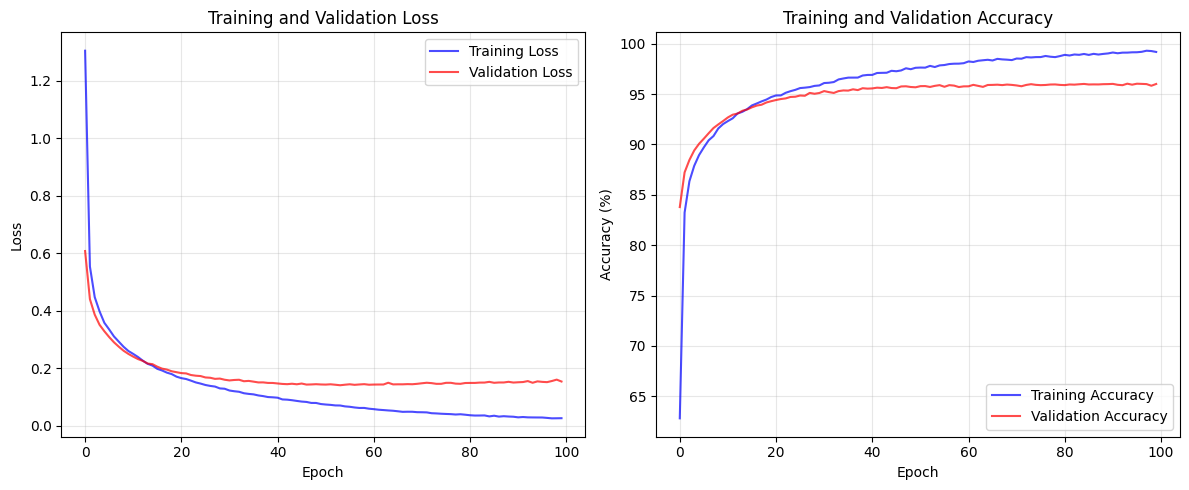


Running t-SNE visualization...
Extracted 10000 samples with 256 dimensions
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.549651
[t-SNE] KL divergence after 250 iterations with early exaggerati

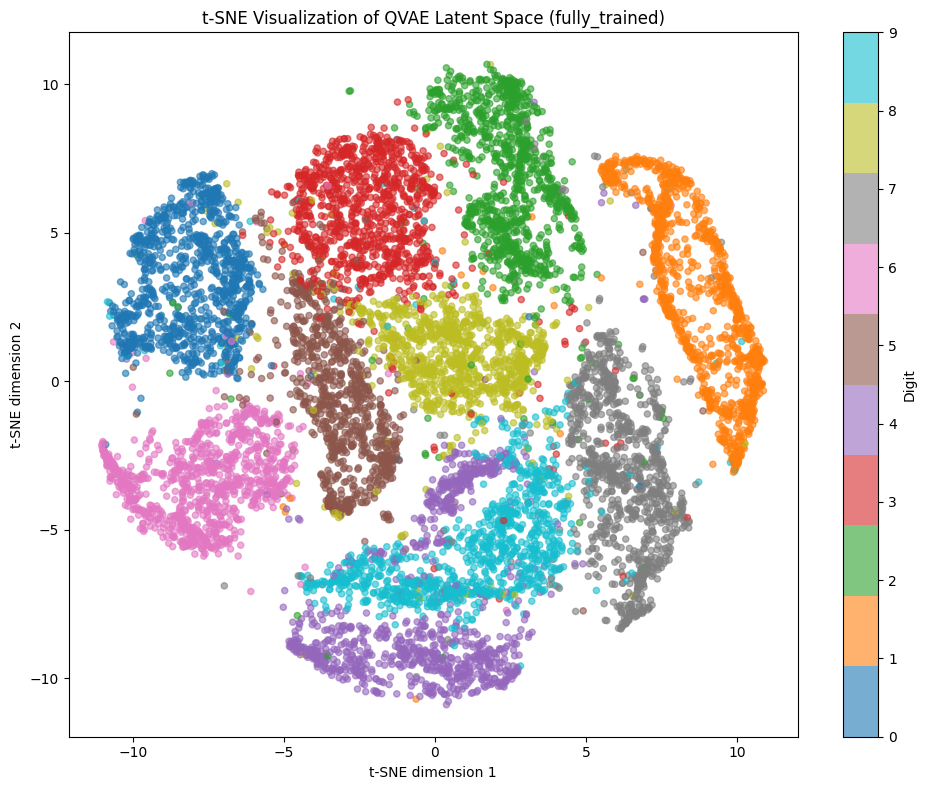

Statistical analysis...
Statistical description per label:
        dim_0                                                              \
        count      mean       std       min       25%       50%       75%   
label                                                                       
0       980.0  0.252856  0.332960  0.000035  0.034279  0.094190  0.261307   
1      1135.0  0.846900  0.226174  0.000861  0.837491  0.926758  0.973063   
2      1032.0  0.346470  0.385603  0.000256  0.042826  0.123877  0.852943   
3      1010.0  0.181546  0.260857  0.000038  0.029708  0.085389  0.178950   
4       982.0  0.358169  0.386123  0.000026  0.045042  0.136794  0.859437   
5       892.0  0.316152  0.370679  0.000034  0.040116  0.111328  0.759942   
6       958.0  0.217838  0.301725  0.000044  0.034718  0.086825  0.213325   
7      1028.0  0.390457  0.400462  0.000098  0.047867  0.149382  0.888443   
8       974.0  0.361775  0.387426  0.000072  0.048414  0.136500  0.854430   
9      1009.0  0.

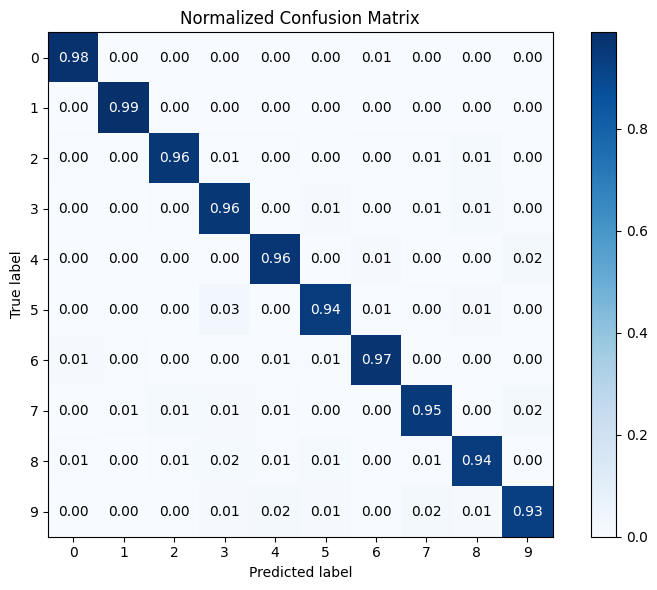

Evaluating final accuracy on test set...
Final Test Accuracy: 96.33%

=== 运行完成 ===
所有结果已保存到: ./models/QVAE_classifier/mnist
最终t-SNE: ./models/QVAE_classifier/mnist/QVAE_final_t-SNE_epochs_20.png
Confusion Matrix: ./models/QVAE_classifier/mnist/QVAE_final_confusion_matrix_epochs.png
训练曲线: ./models/QVAE_classifier/mnist/mlp_training_curves_epochs_100.png


In [4]:
# ============ 主流程 ============
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset_name = 'mnist' #'mnist', 'fashion-mnist', 'kmnist'
    smoke_test = False

    # 设置储存路径
    model_name = "QVAE_classifier"
    save_path = f"./models/{model_name}/{dataset_name}"
    os.makedirs(save_path, exist_ok=True)

    # 初始化Q-VAE参数
    input_dim = 784
    hidden_dim = 512
    latent_dim = 256
    num_var1 = 128
    num_var2 = 128
    dist_beta = 10
    batch_size = 256
    epochs = 2 if smoke_test else 20
    lr = 1e-3
    kl_beta = 0.000001
    weight_decay = 0.01
 
    # 初始化MLP参数
    mlp_epochs = 100
    mlp_lr = 1e-4
    mlp_batch_size = 64

    # 数据加载
    train_loader, test_loader = setup_data_loaders(
        name = dataset_name,
        root = '../../data',
        download = False,
        batch_size =batch_size,
        use_cuda = False  # 如果系统有GPU且已安装CUDA
    )

    # 1. 训练QVAE
    qvae_model_path = os.path.join(save_path, f'qvae_mnist.pth')

    if os.path.exists(qvae_model_path):
        print("Loading pre-trained QVAE model...")
        
        # 创建QVAE模型（参数与训练时完全一致）
        qvae, _ = create_model(
            train_loader, 
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            weight_decay=weight_decay,
            dist_beta=dist_beta, 
            num_var1=num_var1, 
            num_var2=num_var2,
            lr=lr,
            device=device
        )
        
        # 加载预训练权重
        qvae.load_state_dict(torch.load(qvae_model_path, map_location=device))

    else:
        print("Training Q-VAE...")
        qvae = train_qvae(
            device=device,
            train_loader=train_loader,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,  # latent_dim = num_visible + num_hidden
            num_var1=num_var1,
            num_var2=num_var2,
            dist_beta=dist_beta,
            batch_size=batch_size,
            epochs=epochs,
            lr=lr,
            kl_beta=kl_beta,
            save_path=save_path,
        )

    # 2. 从Q-VAE提取潜变量特征zeta
    print("Extracting latent features from Q-VAE...")
    train_features, train_labels = extract_qvae_latent_features(qvae, train_loader)

    # 3. 训练MLP分类器（与经典VAE相同）
    print("Training MLP classifier on Q-VAE latent features...")
    classifier, accuracy, curves_save_path = train_mlp_classifier(
        train_features,
        train_labels,
        device=device,
        epochs=mlp_epochs,
        lr=mlp_lr,
        batch_size=mlp_batch_size,
        smoke_test=smoke_test,
        show=True,
        save_path=save_path,
    )

    # 4. 结果可视化
    print("\nRunning t-SNE visualization...")
    final_tsne_path = os.path.join(save_path, f"QVAE_final_t-SNE_epochs_{epochs}.png")
    df_tsne_final, final_save_path, training_status = t_SNE(
        test_loader, qvae, epochs=epochs, save_path=final_tsne_path, show=True
    )

    print("Statistical analysis...")
    df_stats = describe_statistic_per_label(test_loader, qvae)

    print("Confusion matrix...")
    final_cm_path = os.path.join(save_path, f"QVAE_final_confusion_matrix_epochs.png")
    cm = show_confusion_matrix(
        test_loader,
        qvae,
        classifier,
        device,
        training_status,
        save_path=final_cm_path,
        show=True,
    )  # 传递qvae和classifier

    # 5. 在测试集上评估最终准确率
    print("Evaluating final accuracy on test set...")
    test_features, test_labels = extract_qvae_latent_features(qvae, test_loader)

    test_dataset = TensorDataset(test_features, test_labels)
    test_loader_eval = DataLoader(
        test_dataset, batch_size=mlp_batch_size, shuffle=False
    )

    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader_eval:
            data, target = data.to(device), target.to(device)
            outputs = classifier(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")

    print(f"\n=== 运行完成 ===")
    print(f"所有结果已保存到: {save_path}")
    print(f"最终t-SNE: {final_tsne_path}")
    print(f"Confusion Matrix: {final_cm_path}")
    print(f"训练曲线: {curves_save_path}")